In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import sys, os
import pickle
from torch import nn
import utils.trainutils as tutils
import utils.datautils as dutils
import utils.uqutils as uqutils
import models
from tqdm import tqdm_notebook
import torch.nn.functional as F
from scipy.special import comb
from matplotlib import pyplot as plt

# SETUP GPU
torch.backends.cudnn.benchmark = True
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
base = "/home/rahul/lab_work/data/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def res34(num_class):
    model = torchvision.models.resnet34()
    model.fc = nn.Linear(512, num_class)
    return model

In [30]:
def pretty_print_uq(uq_tuple, init_str='Performance'):
    print(f'{init_str} ==> Accuracy {uq_tuple[0]*100:.2f}%,  '
     f'ECE {uq_tuple[1]*100:.2f}%,  '
     f'NLL {uq_tuple[2]:.4f},  '
     f'Brier {uq_tuple[3]:.4f}'
     )
    
def get_reliability_curve(probs, targets, fn=abs, bins=30):
    preds = np.argmax(probs, axis=1)
    correct = (preds == targets)
    maxprobs = np.max(probs, axis=-1)
    ece_correct, ece_total, ece = uqutils.calculate_ece(maxprobs, correct, nbin=bins, fn=fn)
    xs = np.arange(bins+1)/bins
    ys = [correct/total - x if total >= 5 else 0 for correct,total,x in zip(ece_correct, ece_total, xs)]
    return np.array(xs), np.array(ys)

In [4]:
loader_dict, num_class = dutils.return_loaders(base=base, dataset='CIFAR10', start=1000, end=1500, 
                                               train_shuffle=False, valid_shuffle=False)
np.random.seed(1)
model_file_pattern = 'CIFAR10_ntrain-1000_MixUpAlpha-1.0_id-*.model'
model = models.FastResNet().to(device)
test_probs, targets, model_files = tutils.infer_ensemble(model_file_pattern=model_file_pattern, model=model, 
                                                         dataloader=loader_dict['test'], evalmode=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Number of files found: 10


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


In [23]:
model_performance = []
pooled_test_prob = np.mean(test_probs, axis=0)

for pred in test_probs:
    model_performance.append(uqutils.get_all_scores(pred, targets))

model_performance = np.array(model_performance)
mean_performance = np.mean(model_performance, axis=0)
std_performance = np.std(model_performance, axis=0)
pretty_print_uq(mean_performance, "Mean of individual performance")
pretty_print_uq(std_performance, "Stdev of individual performance")

pooled_performance = uqutils.get_all_scores(pooled_test_prob, targets)
pretty_print_uq(pooled_performance, "Pooled model performance")

Mean of individual performance ==> Accuracy 66.73%,  ECE 7.54%,  NLL 1.0337,  Brier 0.4625
Stdev of individual performance ==> Accuracy 0.31%,  ECE 0.39%,  NLL 0.0080,  Brier 0.0034
Pooled model performance ==> Accuracy 70.28%,  ECE 13.49%,  NLL 0.9668,  Brier 0.4333


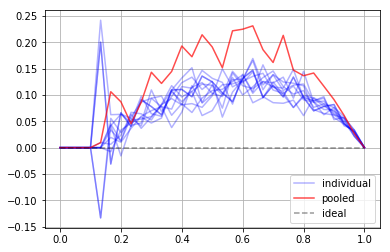

In [31]:
for i,pred in enumerate(test_probs):
    xs, ys = get_reliability_curve(pred, targets)
    if i==0:
        plt.plot(xs, ys, c='b', alpha=0.3, label='individual')
    plt.plot(xs, ys, c='b', alpha=0.3)
    
xs, ys = get_reliability_curve(pooled_test_prob, targets)
plt.plot(xs, ys, c='r', alpha=0.7, label='pooled')
plt.plot([0,1], [0,0], '--k', alpha=0.4, label='ideal')
plt.grid(axis='both')
plt.legend()

In [36]:
pooled_temperature = uqutils.perform_tempscale(pooled_test_prob, targets)
scaled_pooled_test_prob = uqutils.prob_power_t(pooled_test_prob, pooled_temperature)

In [37]:
pooled_temperature

1.4918246976412708